In [4]:
import jax

jax.config.update("jax_enable_x64", True)
import numpy as np
import scipy.stats
from jax import numpy as jnp
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

In [5]:
import os
import sys

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)

In [6]:
import importlib

import probit_network
import random_matrix
import unscented

importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
# importlib.reload(unsc)
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

Roadmap
- orthogonal initialization
- inputs
- layer noise
- train

In [7]:
key = jax.random.PRNGKey(123)

# single layer test

In [8]:
f = ProbitLinear(
    3,
    1,
    key,
    A=RandomOrthogonalProjection(4.0),
    b=RandomOrthogonalProjection(0.0),
    C=RandomOrthogonalProjection(1.0),
    d=RandomOrthogonalProjection(1.0),
)
network = ProbitLinearNetwork(f)

In [9]:
x = 1 + jnp.zeros(f.in_size)
Σ = jnp.eye(x.shape[0]) * 1

In [10]:
mean, cov = f._mc_mean_cov(x, Σ, key, 1_000_000)
mean

Array([0.35777946], dtype=float64)

In [11]:
print("ekf mean", f._propagate_mean_lin(x, Σ))
print("analytic mean", f._propagate_mean(x, Σ))
print("monte carlo mean", mean)

ekf mean [0.9472811]
analytic mean [0.35838089]
monte carlo mean [0.35777946]


In [12]:
np.linalg.eigvalsh(f._propagate_cov(x, Σ))

array([1.82104003])

In [13]:
print("ekf cov", f._propagate_cov_lin(x, Σ))
print("analytic cov", f._propagate_cov(x, Σ))
print("monte carlo covariance", cov)

ekf cov [[1.89707227]]
analytic cov [[1.82104003]]
monte carlo covariance 1.8203032447590575


# Small-variance eigenvalue rectification

In [14]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 2
output_size = 2
hidden_size = 5
network = ProbitLinearNetwork(
    ProbitLinear(
        input_size,
        output_size,
        key1,
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
)
μ = jnp.zeros(input_size)
Σ = jnp.eye(input_size)

In [15]:
mean, cov = network.propagate_mean_cov(μ, Σ * 1e-2, method="analytic")
mean, jnp.linalg.eigvalsh(cov)

(Array([ 0.60679876, -0.39062061], dtype=float64),
 Array([0.00437779, 0.00610912], dtype=float64))

In [16]:
mean, cov = network.propagate_mean_cov(μ, Σ * 1e-2, method="linear")
mean, jnp.linalg.eigvalsh(cov)

(Array([ 0.60915437, -0.39240397], dtype=float64),
 Array([0.00304863, 0.00489059], dtype=float64))

In [17]:
mean, cov = network.propagate_mean_cov(μ, Σ * 1e-2, method="unscented")
mean, jnp.linalg.eigvalsh(cov)

(Array([ 0.60654854, -0.39042887], dtype=float64),
 Array([0.00336702, 0.0053875 ], dtype=float64))

# MLP UQ test

In [18]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(12), 5)
input_size = 2
output_size = 1
hidden_size = 70
layers = [
    ProbitLinear(
        input_size,
        hidden_size,
        key1,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        hidden_size,
        key2,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        hidden_size,
        key3,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
    ProbitLinear(
        hidden_size,
        output_size,
        key4,
        A=RandomOrthogonalProjection(4.0),
        b=RandomOrthogonalProjection(1.0),
        C=RandomOrthogonalProjection(1.0),
        d=ZeroMatrix(),
    ),
]

In [19]:
μ = jnp.zeros(input_size)
Σ = jnp.eye(input_size)

In [20]:
network = ProbitLinearNetwork(*layers)

In [21]:
def plot_mc(ax, μ, Σ):
    μ_unscented, Σ_unscented = network.propagate_mean_cov(μ, Σ, method="unscented")
    μ_lin, Σ_lin = network.propagate_mean_cov(μ, Σ, method="linear")
    μ_adf, Σ_adf = network.propagate_mean_cov(μ, Σ, method="analytic")

    input_samples = jax.random.multivariate_normal(
        key=key, mean=μ, cov=Σ, shape=100_000
    )
    output_samples = jax.vmap(network)(input_samples)
    y_mesh = np.linspace(np.min(output_samples), np.max(output_samples), 2000)

    ax.plot(
        y_mesh,
        scipy.stats.gaussian_kde(output_samples.reshape(-1))(y_mesh),
        label="empirical KDE",
    )
    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=output_samples.mean(), scale=output_samples.std()
        ),
        label="pseudo-true Gaussian fit",
    )

    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=μ_unscented.reshape(-1), scale=Σ_unscented.reshape(-1) ** 0.5
        ),
        label="unscented approximation",
    )

    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=μ_lin.reshape(-1), scale=Σ_lin.reshape(-1) ** 0.5
        ),
        label="linear approximation",
        linestyle="--",
    )

    ax.plot(
        y_mesh,
        scipy.stats.norm.pdf(
            y_mesh, loc=μ_adf.reshape(-1), scale=Σ_adf.reshape(-1) ** 0.5
        ),
        label="my approximation",
        linestyle="--",
    )
    ax.legend()

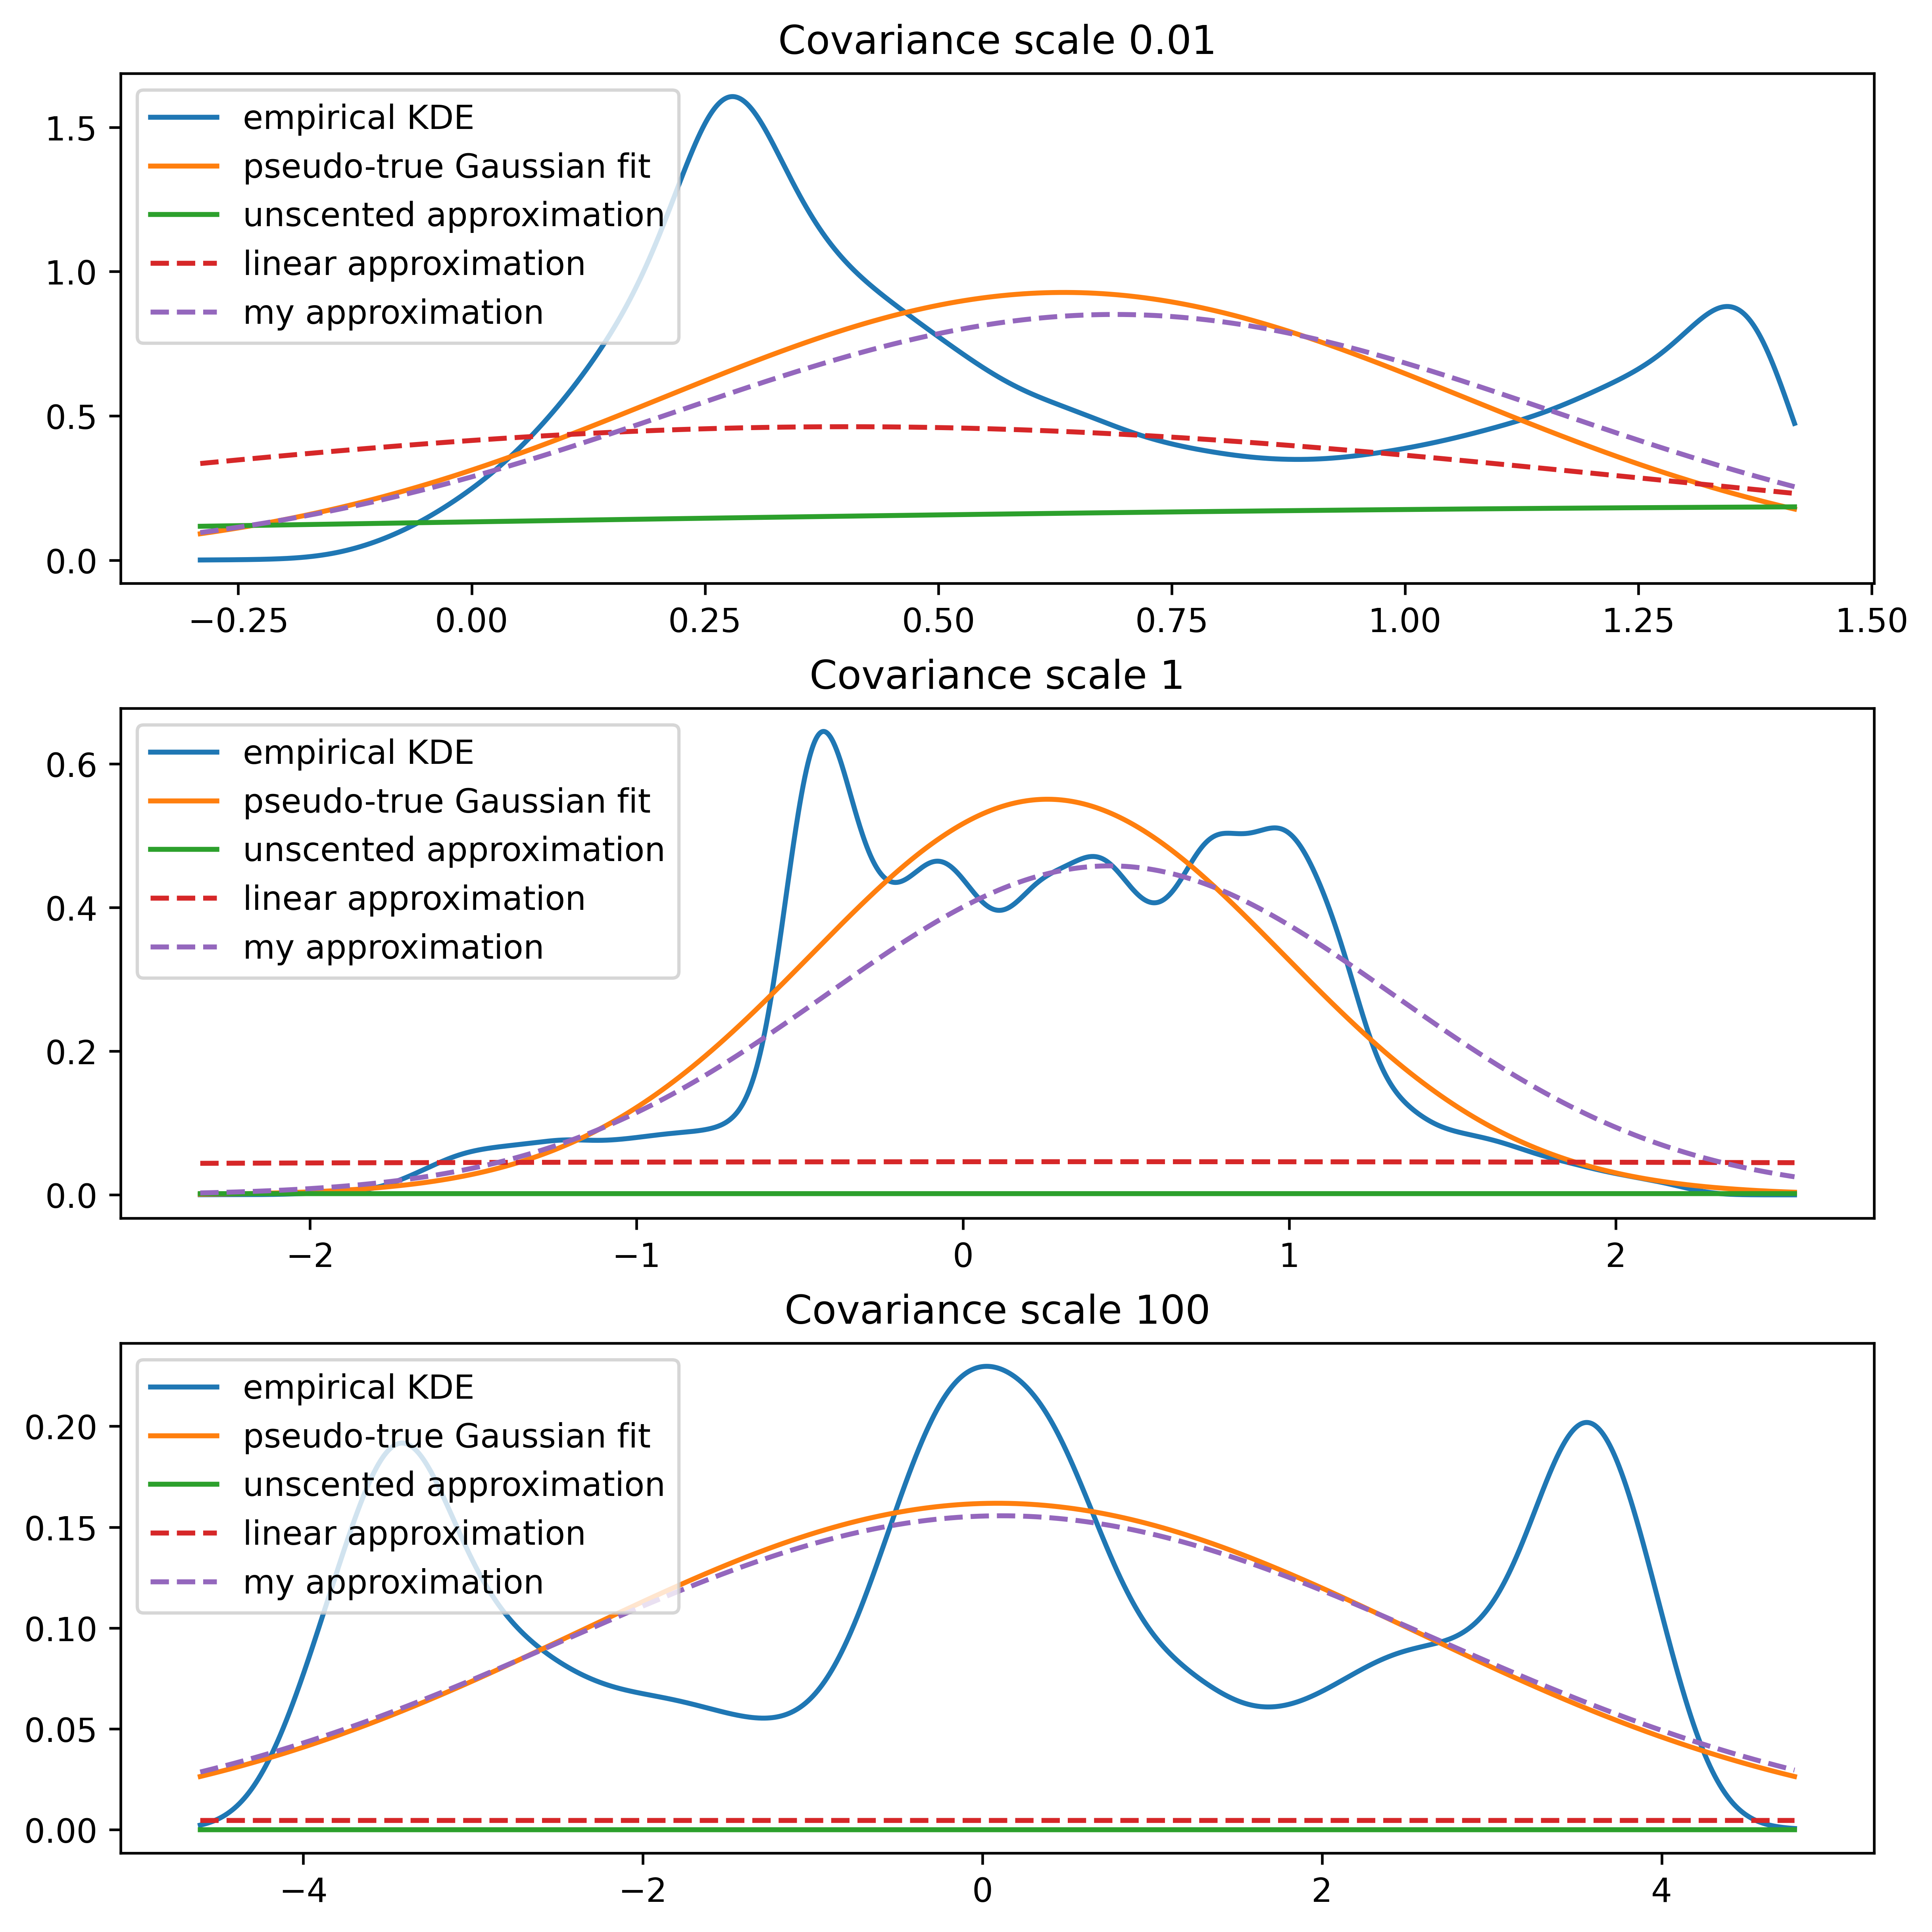

In [22]:
fig = Figure(figsize=(8, 8), dpi=600, constrained_layout=1)
ax = fig.add_subplot(311)
ax.set_title("Covariance scale 0.01")
plot_mc(ax, μ, Σ * 1e-2)
ax = fig.add_subplot(312)
ax.set_title("Covariance scale 1")
plot_mc(ax, μ, Σ * 1)
ax = fig.add_subplot(313)
ax.set_title("Covariance scale 100")
plot_mc(ax, μ, Σ * 1e2)

# fig.savefig("figures/deep-mlp.pdf")
fig

# Kalman filter

In [23]:
import equinox

In [24]:
@equinox.filter_jit
def schur_complement(A, B, C, x, y, method=1):
    """Returns a numerically stable(ish) attempt at
    x + B C^(-1) y,
    A - B C^(-1) B^T.
    """
    if method == 1:
        # C = U U^T
        U = jax.scipy.linalg.cholesky(C)
        # B_tilde = B U^-T
        B_tilde = jax.scipy.linalg.solve_triangular(U, B.T, trans=1, lower=False).T
        return (
            x + B_tilde @ jax.scipy.linalg.solve_triangular(U, y, lower=False),
            A - B_tilde.dot(B_tilde.T),
        )

## random MLP ensemble

In [25]:
import numpy as np


def ccf(*eigenvalues):
    """
    Generate the controllable canonical form (companion matrix) A
    for a system with the given eigenvalues.

    Parameters:
        *eigenvalues: Variable length argument list of eigenvalues (lambda1, lambda2, ..., lambdan)

    Returns:
        A: The controllable canonical form matrix (n x n)
    """
    # Ensure input is treated as a flat list
    eigenvalues = np.array(eigenvalues)

    # Compute the coefficients of the characteristic polynomial
    # The polynomial has the form: s^n + a_{n-1}s^{n-1} + ... + a_1 s + a_0
    poly_coeffs = np.poly(eigenvalues)  # Gives [1, a_{n-1}, ..., a_0]

    # Remove the leading 1 (coefficient of s^n)
    a_coeffs = -poly_coeffs[1:]  # Negative signs for canonical form

    n = len(a_coeffs)
    A = np.zeros((n, n))

    # Fill the last row with the negative coefficients
    A[-1, :] = a_coeffs[::-1]

    # Fill the subdiagonal with 1s
    for i in range(n - 1):
        A[i, i + 1] = 1

    return jnp.array(A)

In [26]:
key, key1, key2, key3, key4 = jax.random.split(jax.random.PRNGKey(21), 5)

n_x = 4
n_u = 1
n_y = 2

n_hidden_output = 100

F = ProbitLinearNetwork(
    ProbitLinear(
        in_size=n_x + n_u,
        out_size=n_x,
        key=key2,
        A=jnp.hstack((ccf(0.99, 0.99, 0.5, -0.3), jnp.zeros((n_x, 1)).at[-1].set(1))),
        b=ZeroMatrix(),
        C=ZeroMatrix(),
        d=ZeroMatrix(),
    ),
)
H = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x + n_u,
        out_size=n_hidden_output,
        key=key3,
        A=RandomOrthogonalProjection(1e1),
        b=RandomOrthogonalProjection(1e1),
    ),
    ProbitLinear.create_probit(
        in_size=n_hidden_output,
        out_size=n_y,
        key=key4,
        A=RandomOrthogonalProjection(1e1),
        b=ZeroMatrix(),
    ),
)
H_aug = H.augment_with_identity()

In [27]:
x = F(np.zeros(n_x + n_u))

In [28]:
sim_horizon = 200
Q = jnp.eye(n_x) * 1e-2
R = jnp.eye(n_y) * 1e-4

In [29]:
η_key, ϵ_key = jax.random.split(key, 2)

In [30]:
η = jax.random.multivariate_normal(
    mean=jnp.zeros(n_x), cov=Q, key=η_key, shape=sim_horizon
)

In [31]:
ϵ = jax.random.multivariate_normal(
    mean=jnp.zeros(n_y), cov=R, key=ϵ_key, shape=sim_horizon
)

In [32]:
u = np.zeros((sim_horizon, n_u))
u[100:] = 10

In [33]:
x = np.zeros((sim_horizon, n_x))
y = np.zeros((sim_horizon, n_y))
y_noiseless = np.zeros((sim_horizon, n_y))
for i in range(1, sim_horizon):
    x[i, :] = F(x[i - 1, :], u[i - 1, :]) + η[i - 1]
    y_noiseless[i, :] = H(x[i, :], u[i - 1,])
    y[i, :] = y_noiseless[i, :] + ϵ[i]

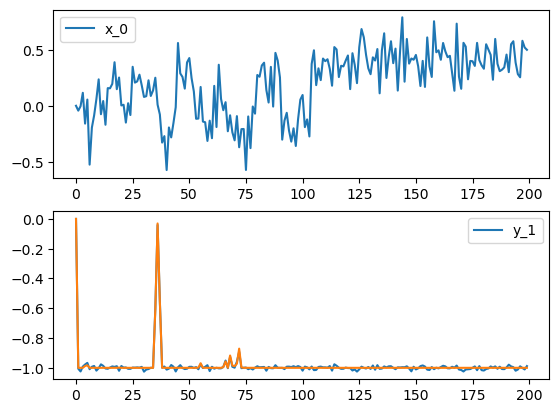

In [34]:
fig = Figure()
ax = fig.add_subplot(211)
ax.plot(x[:, 0], label="x_0")
ax.legend()
ax = fig.add_subplot(212)
ax.plot(y[:, 0], label="y_1")
ax.plot(y_noiseless[:, 0])
ax.legend()
fig

In [35]:
STATES = slice(None, n_x)
INPUTS = slice(n_x, n_x + n_u)
OUTPUTS = slice(n_x + n_u, None)
JOINT = slice(None, n_x + n_u + n_y)

joint_prediction = np.zeros((sim_horizon, n_x + n_u + n_y))
P_pred = np.zeros((sim_horizon, n_x + n_u + n_y, n_x + n_u + n_y))
P_post = np.zeros((sim_horizon, n_x, n_x))

joint_prediction[0, STATES] = 0
P_pred[0, STATES, STATES] = Q * 1
P_post[0, STATES, STATES] = Q * 1

In [36]:
method = "analytic"

In [37]:
for i in trange(1, sim_horizon):
    # predict x
    joint_prediction[i, STATES], P_pred[i, STATES, STATES] = F.propagate_mean_cov_block(
        (joint_prediction[i - 1, STATES], u[i - 1, :]),
        (P_post[i - 1, STATES, STATES], 0.0),
        method=method,
    )
    P_pred[i, STATES, STATES] += Q
    # predict y
    joint_prediction[i, JOINT], P_pred[i, JOINT, JOINT] = (
        H_aug.propagate_mean_cov_block(
            (joint_prediction[i, STATES], u[i - 1, :]),
            (P_pred[i, STATES, STATES], 0.0),
            method=method,
        )
    )
    P_pred[i, OUTPUTS, OUTPUTS] += R
    # correct x
    joint_prediction[i, STATES], P_post[i, STATES, STATES] = schur_complement(
        P_pred[i, STATES, STATES],
        P_pred[i, STATES, OUTPUTS],
        P_pred[i, OUTPUTS, OUTPUTS],
        joint_prediction[i, STATES],
        y[i, :] - joint_prediction[i, OUTPUTS],
    )
    if np.any(np.isnan(joint_prediction[i])):
        print(i)
        raise KeyboardInterrupt

  0%|          | 0/199 [00:00<?, ?it/s]

In [38]:
x_pred = joint_prediction[:, STATES]
x_pred_std = jax.vmap(jnp.diag)(P_pred[:, STATES, STATES]) ** 0.5
y_pred = joint_prediction[:, OUTPUTS]
y_pred_std = jax.vmap(jnp.diag)(P_pred[:, OUTPUTS, OUTPUTS]) ** 0.5

In [39]:
print(((x - x_pred) ** 2).mean() ** 0.5, np.std(x))

0.21610239383536323 0.4362175869526286


In [40]:
time_slice = slice(1, None)

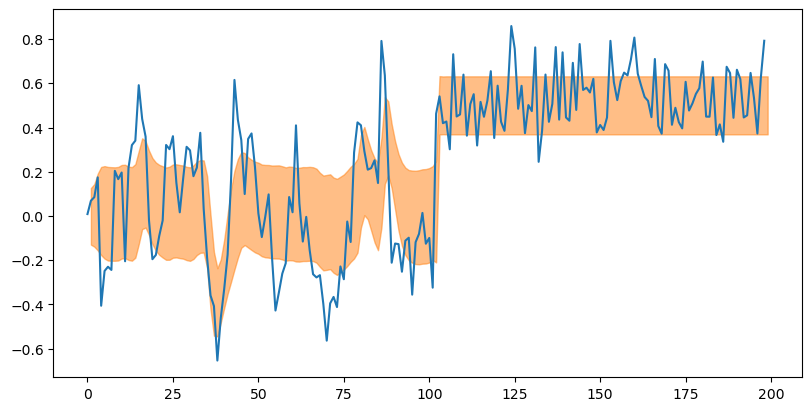

In [41]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(x[time_slice, 1])
ax.fill_between(
    np.arange(sim_horizon)[time_slice],
    (x_pred[time_slice, 1] - x_pred_std[time_slice, 1]),
    (x_pred[time_slice, 1] + x_pred_std[time_slice, 1]),
    color="C1",
    alpha=0.5,
)
fig

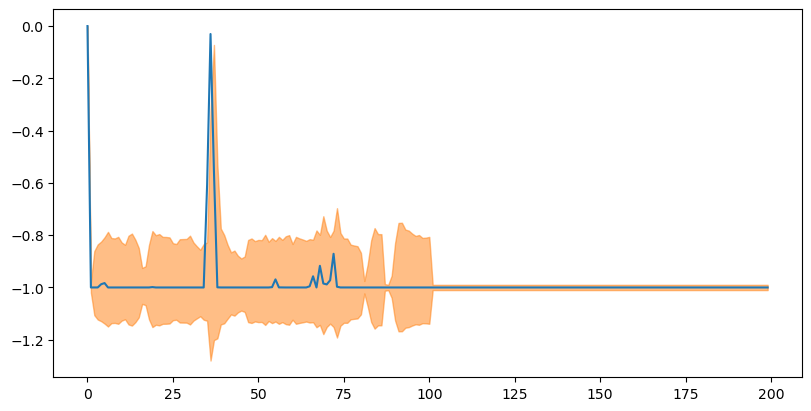

In [42]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(y_noiseless[:, 0])
# ax.plot(y_pred[:, 1])
ax.fill_between(
    np.arange(sim_horizon),
    y_pred[:, 0] - y_pred_std[:, 0],
    y_pred[:, 0] + y_pred_std[:, 0],
    color="C1",
    alpha=0.5,
)
fig